In [2]:
import pandas as pd 
import numpy as np
import xgboost as xgb
from sklearn import metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import StratifiedKFold, train_test_split
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
root = '../'
X_train = pd.read_csv(root + 'data/Haleh/feature_datasets/X_train.csv')
X_train_full = pd.read_csv(root + 'data/Haleh/feature_datasets/X_train_dec.csv')
X_test = pd.read_csv(root + 'data/Haleh/feature_datasets/X_test.csv')
X_test_full = pd.read_csv(root + 'data/Haleh/feature_datasets/X_test_dec.csv')

y_train = np.load(root + 'data/Haleh/y_train.npy')
y_test = np.load(root + 'data/Haleh/y_test.npy')

In [4]:
X_train_full.head()

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,...,0__fourier_entropy__bins_2,0__fourier_entropy__bins_3,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1
0,-4.102828,12.117376,2.979742,6.824316,8.521718,-3.394531,3.834200,-5.100700,-0.607759,0.902113,...,0.079983,0.079983,0.170467,0.280179,0.597595,1.203390,1.766804,2.354477,2.933702,3.466107
1,-6.215706,12.255225,22.190172,-0.212288,-5.466818,-28.439009,-11.580964,11.495201,-4.141428,10.182698,...,0.163982,0.247940,0.327050,0.488548,0.796679,1.198716,1.766011,2.367617,2.970901,3.556645
2,-6.349346,12.251351,22.159270,-0.396654,-5.702261,-28.601473,-11.648271,11.519348,-4.056820,10.192198,...,0.210883,0.275463,0.408537,0.482843,0.907649,1.201300,1.770794,2.372899,2.981178,3.582805
3,-1.180088,-9.493090,12.479339,2.376886,3.711802,-5.103728,0.372605,11.038977,-3.201739,-4.864267,...,0.110453,0.155665,0.280179,0.452701,0.859510,1.256123,1.882432,2.550049,3.222475,3.874065
4,-1.003413,-10.825782,13.547513,2.483605,4.324685,-5.714592,0.728139,12.329692,-3.472347,-5.438126,...,0.110453,0.159721,0.235155,0.412056,0.741638,1.240362,1.833065,2.450065,3.049852,3.636782


In [114]:
params='gbtree': {'alpha': 0.00011694817964831821,
   'booster': 'gbtree',
   'colsample_bytree': 0.6043404266251264,
   'eta': 3.134211168746621e-06,
   'gamma': 3.3469061734550824e-06,
   'grow_policy': 'lossguide',
   'lambda': 0.0058067522522555395,
   'learning_rate': 0.27242751486347067,
   'max_delta_step': 0.0003490592900466461,
   'max_depth': 13,
   'min_child_weight': 62.25065974497102,
   'num_boost_round': 537,
   'objective': 'binary:logistic',
   'scale_pos_weight': 5,
   'subsample': 0.6392203423892042,
   'verbosity': 0}

In [24]:
space={'max_depth': hp.randint("max_depth", 3, 18),
       'gamma': hp.uniform ('gamma', 0, 2),
       'alpha' : hp.uniform('alpha', 0, 2),
       'lambda' : hp.uniform('lambda', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
       'min_child_weight' : hp.uniform('min_child_weight', 0, 100),
       'eta': hp.uniform('subsample', 0, 0.4),
       'seed': 0,
       'scale_pos_weight': 6,
    }

In [25]:

def objective_dec(space):
    params = space
    
    n_splits = 3
    skf = StratifiedKFold(n_splits)
    
    auc = 0.0
    for train_index, eval_index in skf.split(X_train_full, y_train):
        x_train_split = X_train_full[X_train_full.index.isin(train_index)]
        x_eval_split = X_train_full[X_train_full.index.isin(eval_index)]
        y_train_split = y_train[train_index]
        y_eval_split = y_train[eval_index]
        
        clf=xgb.XGBClassifier(**params, n_estimators=100, use_label_encoder=False)

        evaluation = [(x_train_split, y_train_split), (x_eval_split, y_eval_split)]

        clf.fit(x_train_split, y_train_split,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=12,verbose=False)


        pred = clf.predict_proba(x_eval_split)[:, 1]
        auc += metrics.roc_auc_score(y_eval_split, pred)
        
    auc /= n_splits
    print (f"SCORE: \t\t{auc:.3f}")
    return {'loss': -auc, 'status': STATUS_OK }

def objective(space):
    params = space
    n_splits = 3
    skf = StratifiedKFold(n_splits)
    auc = 0.0
    for train_index, eval_index in skf.split(X_train, y_train):
        x_train_split = X_train[X_train.index.isin(train_index)]
        x_eval_split = X_train[X_train.index.isin(eval_index)]
        y_train_split = y_train[train_index]
        y_eval_split = y_train[eval_index]
        
        clf=xgb.XGBClassifier(**params, use_label_encoder=False)
    
        evaluation = [(x_train_split, y_train_split), (x_eval_split, y_eval_split)]
    
        clf.fit(x_train_split, y_train_split,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)


        pred = clf.predict_proba(x_eval_split)[:, 1]
        auc += metrics.roc_auc_score(y_eval_split, pred)
        
    auc /= n_splits

    print (f"SCORE: \t\t{auc:.3f}")
    return {'loss': -auc, 'status': STATUS_OK }

In [26]:
trials_standard = Trials()

best_hyperparams_standard = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials_standard)



SCORE: 		0.676                                                                                                                                                            
SCORE: 		0.676                                                                                                                                                            
SCORE: 		0.646                                                                                                                                                            
SCORE: 		0.661                                                                                                                                                            
SCORE: 		0.659                                                                                                                                                            
SCORE: 		0.663                                                                                                                                   

In [27]:
trials_dec = Trials()

best_hyperparams_dec = fmin(fn = objective_dec,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials_dec)

SCORE: 		0.666                                                                                                                                                            
SCORE: 		0.674                                                                                                                                                            
SCORE: 		0.667                                                                                                                                                            
SCORE: 		0.688                                                                                                                                                            
SCORE: 		0.658                                                                                                                                                            
SCORE: 		0.682                                                                                                                                   

In [28]:
with open('study_gb_tree_features_wo_dec_scalePosWeights_6.pickle', 'wb') as handle:
    pickle.dump(trials_standard, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('params_gb_tree_features_wo_dec_scalePosWeights_6.pickle', 'wb') as handle:
    pickle.dump(best_hyperparams_standard, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('study_gb_tree_features_with_dec_scalePosWeights_6.pickle', 'wb') as handle:
    pickle.dump(trials_dec, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('params_gb_tree_features_with_dec_scalePosWeights_6.pickle', 'wb') as handle:
    pickle.dump(best_hyperparams_dec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
best_params_list = []
file_names = [('params_gb_tree_features_wo_dec_scalePosWeights_6.pickle', 'Feature_DS'), 
              ('params_gb_tree_features_with_dec_scalePosWeights_6.pickle', 'DEC_Feature_DS')]
              #('params_gb_tree_features_wo_dec_scalePosWeights_1.pickle', 'Feature_DS'), 
              #('params_gb_tree_features_with_dec_scalePosWeights_1.pickle', 'DEC_Feature_DS')]

params={'objective': 'binary:logistic',
        'scale_pos_weight': 6,
        'verbosity': 0,
        'booster': 'gbtree',
        'grow_policy': 'lossguide',
    }

for file_name, dataset_name in file_names:
    with (open(file_name, "rb")) as openfile:
        while True:
            try:
                best_params = pickle.load(openfile)
                
                for key, value in params.items():
                    best_params[key] = value
                    
                if file_name.find("1") != -1:
                    print('found 1')
                    best_params["scale_pos_weight"] = 1
                else: 
                    best_params["scale_pos_weight"] = 6
                
                best_params_list.append((best_params, dataset_name))
            except EOFError:
                break

In [31]:
print(best_params_list)

[({'alpha': 0.20346544644852352, 'colsample_bytree': 0.40961242339413906, 'gamma': 1.2796780056729506, 'lambda': 0.9268460304911162, 'max_depth': 17, 'min_child_weight': 18.88004563201531, 'subsample': 0.10839079348122321, 'objective': 'binary:logistic', 'scale_pos_weight': 6, 'verbosity': 0, 'booster': 'gbtree', 'grow_policy': 'lossguide'}, 'Feature_DS'), ({'alpha': 1.9601000182154007, 'colsample_bytree': 0.7147836913604044, 'gamma': 1.7961724509715353, 'lambda': 0.5471616928882781, 'max_depth': 16, 'min_child_weight': 18.517349939521033, 'subsample': 0.0855463953727625, 'objective': 'binary:logistic', 'scale_pos_weight': 6, 'verbosity': 0, 'booster': 'gbtree', 'grow_policy': 'lossguide'}, 'DEC_Feature_DS')]


In [32]:
results = {}

n_estimators = 100
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

for params, dataset_name in best_params_list:
    
    if dataset_name == 'Feature_DS':
        train, test = X_train, X_test
    elif dataset_name == 'DEC_Feature_DS':
        train, test = X_train_full, X_test_full
    
    booster_params = params
    print(f'Evaluating {dataset_name} dataset')
    datasets_results = {}
    booster_type = 'gbtree'
    
    print(booster_type)
    print(booster_params)
    booster_params['eval_metric'] = 'auc'
    cv_results = {'f1': [],
                  'roc': [],
                  'pr': [],
                  'rc': [],
                  'acc': [],
                  'eval_result': []
                 }

    for train_index, eval_index in skf.split(train, y_train):
        x_train_split = train[train.index.isin(train_index)]
        x_eval_split = train[train.index.isin(eval_index)]
        y_train_split = y_train[train_index]
        y_eval_split = y_train[eval_index]

        eval_set = [(x_train_split, y_train_split), (x_eval_split, y_eval_split)]

        xgb_default = xgb.XGBClassifier(**booster_params, n_estimators=n_estimators)
        xgb_default.fit(x_train_split, 
                      y_train_split, 
                      eval_set=eval_set, 
                       early_stopping_rounds=5)

        y_pred_proba = xgb_default.predict_proba(test)[:, 1]
        y_pred_classes = xgb_default.predict(test)
        cv_results['eval_result'].append(xgb_default.evals_result())

        cv_results['f1'].append(metrics.f1_score(y_test, y_pred_classes))
        cv_results['roc'].append(metrics.roc_auc_score(y_test, y_pred_classes))
        cv_results['acc'].append(metrics.balanced_accuracy_score(y_test, y_pred_classes))
        cv_results['pr'].append(metrics.precision_score(y_test, y_pred_classes))
        cv_results['rc'].append(metrics.recall_score(y_test, y_pred_classes))

    scores = {'ROC-AUC Score': [np.mean(np.array(cv_results['roc'])), np.std(np.array(cv_results['roc']))],
              'F1 Score': [np.mean(np.array(cv_results['f1'])), np.std(np.array(cv_results['f1']))],
              'Precision': [np.mean(np.array(cv_results['pr'])), np.std(np.array(cv_results['pr']))],
              'Recall': [np.mean(np.array(cv_results['rc'])), np.std(np.array(cv_results['rc']))],
              'Balanced Accuracy': [np.mean(np.array(cv_results['acc'])), np.std(np.array(cv_results['acc']))]}
    print('########## RESULTS ##########')
    print(json.dumps(scores, indent=4))
    print()
    datasets_results[booster_type] = {'proba_predictions': y_pred_proba,
                                      'class_predictions': y_pred_classes,
                                      'scores': scores,
                                      'eval_results': cv_results['eval_result']
                                     }
    results[dataset_name] = datasets_results

    print()

Evaluating Feature_DS dataset
gbtree
{'alpha': 0.20346544644852352, 'colsample_bytree': 0.40961242339413906, 'gamma': 1.2796780056729506, 'lambda': 0.9268460304911162, 'max_depth': 17, 'min_child_weight': 18.88004563201531, 'subsample': 0.10839079348122321, 'objective': 'binary:logistic', 'scale_pos_weight': 6, 'verbosity': 0, 'booster': 'gbtree', 'grow_policy': 'lossguide'}
[0]	validation_0-auc:0.58142	validation_1-auc:0.55632
[1]	validation_0-auc:0.61032	validation_1-auc:0.54722
[2]	validation_0-auc:0.62318	validation_1-auc:0.54886
[3]	validation_0-auc:0.64591	validation_1-auc:0.55775
[4]	validation_0-auc:0.65331	validation_1-auc:0.56830
[5]	validation_0-auc:0.66471	validation_1-auc:0.57641
[6]	validation_0-auc:0.67392	validation_1-auc:0.57268
[7]	validation_0-auc:0.67410	validation_1-auc:0.55154
[8]	validation_0-auc:0.68579	validation_1-auc:0.56150
[9]	validation_0-auc:0.68952	validation_1-auc:0.55580
[10]	validation_0-auc:0.68552	validation_1-auc:0.55566


/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.59952	validation_1-auc:0.59172
[1]	validation_0-auc:0.60704	validation_1-auc:0.58744
[2]	validation_0-auc:0.62021	validation_1-auc:0.59661
[3]	validation_0-auc:0.63652	validation_1-auc:0.62067
[4]	validation_0-auc:0.64498	validation_1-auc:0.62365
[5]	validation_0-auc:0.65134	validation_1-auc:0.63141
[6]	validation_0-auc:0.66049	validation_1-auc:0.61254
[7]	validation_0-auc:0.66297	validation_1-auc:0.59579
[8]	validation_0-auc:0.65977	validation_1-auc:0.57603
[9]	validation_0-auc:0.66140	validation_1-auc:0.56001
[10]	validation_0-auc:0.66106	validation_1-auc:0.56758
[0]	validation_0-auc:0.58866	validation_1-auc:0.56542
[1]	validation_0-auc:0.59471	validation_1-auc:0.55823
[2]	validation_0-auc:0.62692	validation_1-auc:0.53445
[3]	validation_0-auc:0.62875	validation_1-auc:0.53673
[4]	validation_0-auc:0.64148	validation_1-auc:0.53849
[5]	validation_0-auc:0.63848	validation_1-auc:0.54105


/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.57467	validation_1-auc:0.52564
[1]	validation_0-auc:0.59063	validation_1-auc:0.53248
[2]	validation_0-auc:0.62544	validation_1-auc:0.53975
[3]	validation_0-auc:0.62886	validation_1-auc:0.55085
[4]	validation_0-auc:0.62800	validation_1-auc:0.58566
[5]	validation_0-auc:0.63463	validation_1-auc:0.56865
[6]	validation_0-auc:0.64652	validation_1-auc:0.59170
[7]	validation_0-auc:0.64478	validation_1-auc:0.57184
[8]	validation_0-auc:0.65560	validation_1-auc:0.57637
[9]	validation_0-auc:0.66093	validation_1-auc:0.58055
[10]	validation_0-auc:0.66806	validation_1-auc:0.58667
[0]	validation_0-auc:0.58949	validation_1-auc:0.55389
[1]	validation_0-auc:0.60675	validation_1-auc:0.58815
[2]	validation_0-auc:0.61409	validation_1-auc:0.58437
[3]	validation_0-auc:0.61348	validation_1-auc:0.59120
[4]	validation_0-auc:0.63072	validation_1-auc:0.57875
[5]	validation_0-auc:0.64339	validation_1-auc:0.56427
[6]	validation_0-auc:0.64079	validation_1-auc:0.54036
[7]	validation_0-auc:0.6486

/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.55400	validation_1-auc:0.56082
[1]	validation_0-auc:0.58717	validation_1-auc:0.58757
[2]	validation_0-auc:0.58998	validation_1-auc:0.58278
[3]	validation_0-auc:0.60550	validation_1-auc:0.59672
[4]	validation_0-auc:0.62455	validation_1-auc:0.58445
[5]	validation_0-auc:0.63781	validation_1-auc:0.60256
[6]	validation_0-auc:0.63201	validation_1-auc:0.59012
[7]	validation_0-auc:0.65210	validation_1-auc:0.59575
[8]	validation_0-auc:0.65689	validation_1-auc:0.59325
[9]	validation_0-auc:0.66555	validation_1-auc:0.59016
[10]	validation_0-auc:0.67268	validation_1-auc:0.59622
[0]	validation_0-auc:0.58019	validation_1-auc:0.56766
[1]	validation_0-auc:0.61864	validation_1-auc:0.56332
[2]	validation_0-auc:0.64401	validation_1-auc:0.57564
[3]	validation_0-auc:0.66432	validation_1-auc:0.59607
[4]	validation_0-auc:0.67036	validation_1-auc:0.59984
[5]	validation_0-auc:0.67749	validation_1-auc:0.60038
[6]	validation_0-auc:0.66784	validation_1-auc:0.59169
[7]	validation_0-auc:0.6725

/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-auc:0.67977	validation_1-auc:0.60072
[0]	validation_0-auc:0.57945	validation_1-auc:0.57379
[1]	validation_0-auc:0.60705	validation_1-auc:0.61699
[2]	validation_0-auc:0.63965	validation_1-auc:0.61614
[3]	validation_0-auc:0.64185	validation_1-auc:0.60433
[4]	validation_0-auc:0.64031	validation_1-auc:0.60664
[5]	validation_0-auc:0.64162	validation_1-auc:0.59604
[6]	validation_0-auc:0.64867	validation_1-auc:0.60325


/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.58122	validation_1-auc:0.62977
[1]	validation_0-auc:0.60008	validation_1-auc:0.62970
[2]	validation_0-auc:0.61680	validation_1-auc:0.61722
[3]	validation_0-auc:0.63043	validation_1-auc:0.64739
[4]	validation_0-auc:0.63828	validation_1-auc:0.66478
[5]	validation_0-auc:0.63832	validation_1-auc:0.65869
[6]	validation_0-auc:0.64788	validation_1-auc:0.65781
[7]	validation_0-auc:0.65266	validation_1-auc:0.66652
[8]	validation_0-auc:0.65917	validation_1-auc:0.68194
[9]	validation_0-auc:0.66698	validation_1-auc:0.66726
[10]	validation_0-auc:0.67965	validation_1-auc:0.67146
[11]	validation_0-auc:0.67994	validation_1-auc:0.66843
[12]	validation_0-auc:0.67677	validation_1-auc:0.65368
[13]	validation_0-auc:0.68476	validation_1-auc:0.65995
[0]	validation_0-auc:0.54733	validation_1-auc:0.55045
[1]	validation_0-auc:0.57533	validation_1-auc:0.55777
[2]	validation_0-auc:0.57229	validation_1-auc:0.51142
[3]	validation_0-auc:0.61040	validation_1-auc:0.54839
[4]	validation_0-auc:0.6

/Users/Paul/miniforge3/envs/xgboost/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [104]:
result_dict = results['Feature_DS']['gblinear']['eval_results']
score_dict = results['']

train_results = []
eval_results = []
df_train = pd.DataFrame(columns=['AUC', 'Fold', 'Num_Trees'])
df_eval = pd.DataFrame(columns=['AUC', 'Fold', 'Num_Trees'])
num_trees = np.arange(1, n_estimators+1, 1)
tree_shape = num_trees.shape
print(tree_shape)
#print(len(result_dict[0]['validation_0']['auc']))
fold_temp = np.ones(tree_shape)
df_train_list = []
df_eval_list = []

auc_array = np.zeros((n_splits, n_estimators))

for fold, fold_result in enumerate(result_dict):
    #print(fold_result['validation_0']['auc'])
    #print(train_results)
    train_arr = np.stack([fold_result['validation_0']['auc'],
                                          np.full(tree_shape, fold),
                                          num_trees])
    val_arr = np.stack([fold_result['validation_1']['auc'],
                                          np.full(tree_shape, fold),
                                          num_trees])
    #print(train_arr.shape)
    
    df_train_list.append(pd.DataFrame(train_arr.T, columns=['AUC', 'Fold', 'Num_Trees']))
    df_eval_list.append(pd.DataFrame(val_arr.T, columns=['AUC', 'Fold', 'Num_Trees']))
    
    auc_array[fold, :] = val_arr[0, :]

    
mean_eval_score = np.mean(auc_array, axis=0)
best_ntree_limit = np.argmax(mean_eval_score)
df_train = pd.concat(df_train_list, ignore_index=True)
df_eval = pd.concat(df_eval_list, ignore_index=True)
    #train_results.append(fold_result['validation_0']['auc'])
    #eval_results.append(fold_result['validation_1']['auc'])
    #print(f'Optimal Tree Number: {}')
#train_results = np.stack(train_results, axis=0)
#eval_results = np.stack(eval_results, axis=0)
#print(train_results.shape)
                                                    


(40,)


In [105]:
mean_eval_score

array([0.6405522, 0.64879  , 0.654438 , 0.6582694, 0.6605964, 0.6615962,
       0.6622898, 0.6626808, 0.6629664, 0.6628036, 0.6627712, 0.6624064,
       0.6618024, 0.6611776, 0.6604818, 0.659973 , 0.659397 , 0.65893  ,
       0.6585074, 0.6580582, 0.6574442, 0.6569464, 0.656557 , 0.655989 ,
       0.6554936, 0.6548824, 0.6544982, 0.6540302, 0.6536268, 0.6531502,
       0.6528146, 0.6524252, 0.651911 , 0.651484 , 0.6511676, 0.6509134,
       0.650675 , 0.6502914, 0.6499772, 0.6497036])

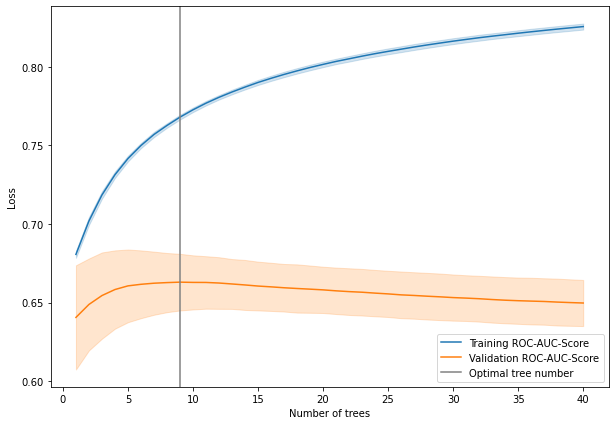

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(10,7))

sns.lineplot(data=df_train, x="Num_Trees", y="AUC", label="Training ROC-AUC-Score", ci='sd')
sns.lineplot(data=df_eval, x="Num_Trees", y="AUC", label="Validation ROC-AUC-Score", ci='sd')
#plt.axvline(21, color="gray", label="Optimal tree number")
plt.axvline(best_ntree_limit+1, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

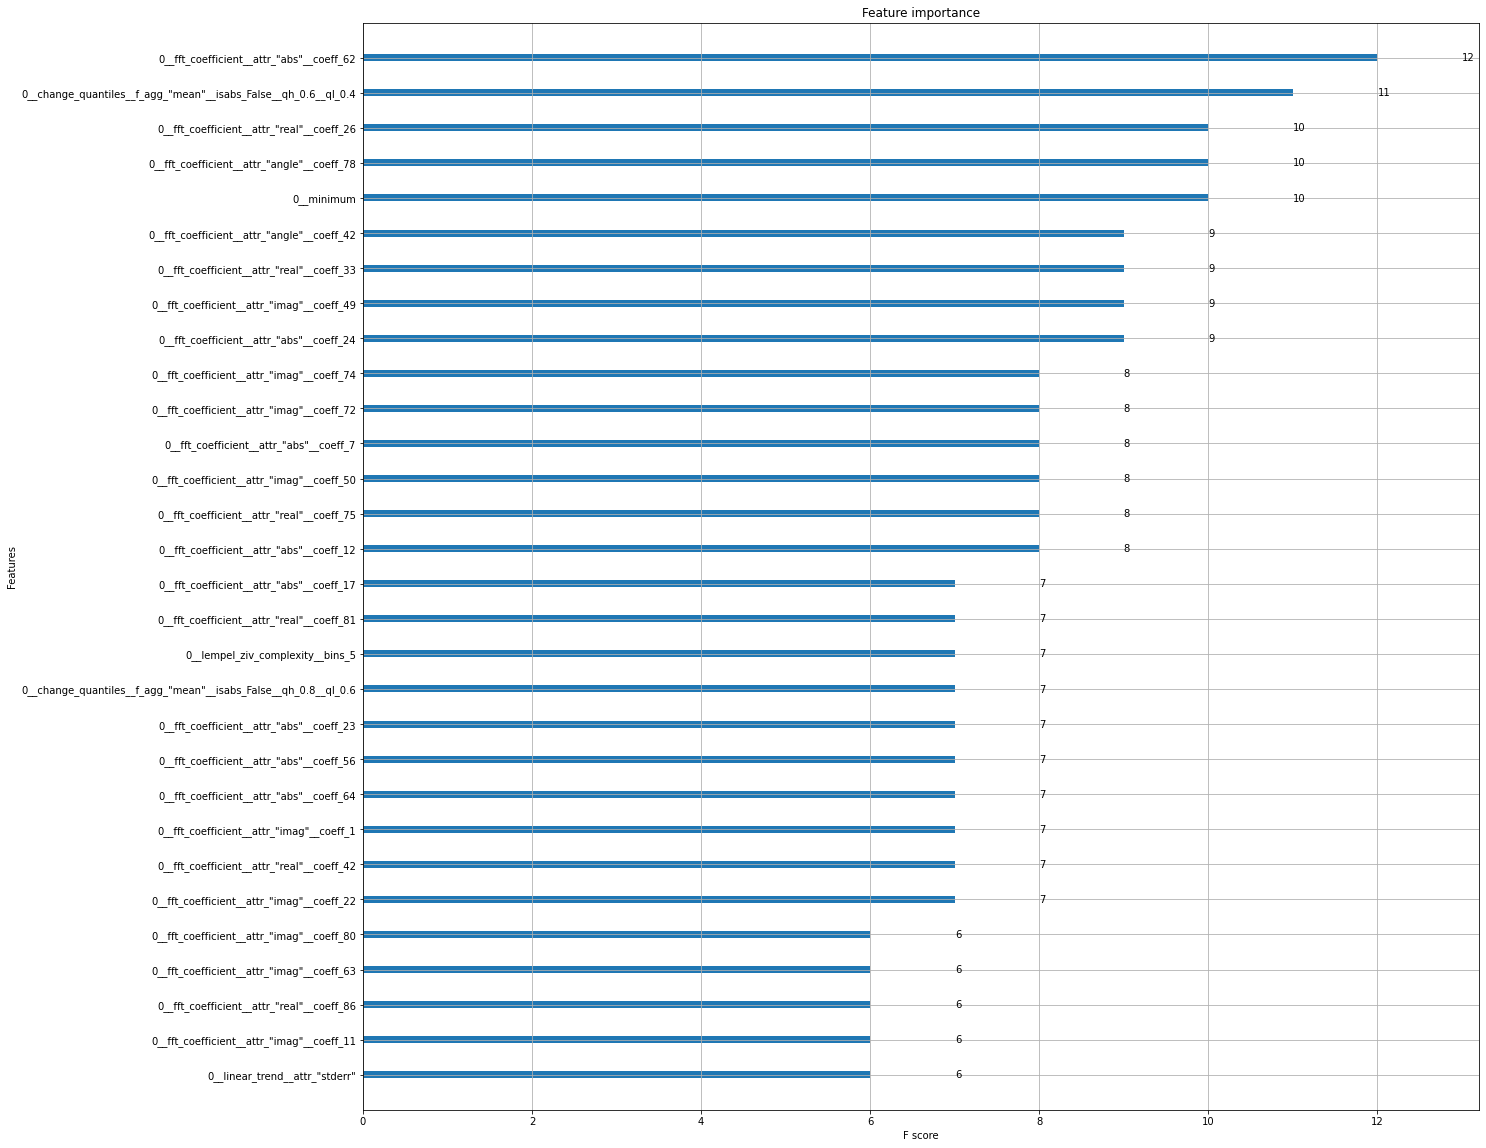

In [174]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(xgb_default, max_num_features=30, ax=ax)